In [1]:
#!/usr/bin/env python
# coding: utf-8

"""人工データ生成モジュール

このモジュールでは、論文で扱われている3種類の人工データを生成する。

生成される3種類のデータセット:
    1. AR(2)モデル + 平均が飛び変わる（分散は一定）
    2. AR(2)モデル + 平均が小さく飛び変わる + ノイズ分散が徐々に変化 
    3. 分散のみが大きく/小さく飛び変わる（平均は一定, iidに近い設定）

各データセットは長さ10,000の時系列データで、t=1000,2000,...,9000を変化点として設定した。
"""

import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["legend.fancybox"] = False # 丸角
plt.rcParams["legend.framealpha"] = 1 # 透明度の指定、0で塗りつぶしなし
plt.rcParams["legend.edgecolor"] = 'black' # edgeの色を変更
plt.rcParams["legend.handlelength"] = 1.2 # 凡例の線の長さを調節
plt.rcParams["legend.labelspacing"] = 0.05 # 垂直方向（縦）の距離の各凡例の距離
plt.rcParams["legend.handletextpad"] = 0.5 # 凡例の線と文字の距離の長さ
plt.rcParams["legend.markerscale"] = 1 # 点がある場合のmarker scale
plt.rcParams['font.weight'] = 'medium' # 線の太さ
plt.rcParams['font.size'] = 30 # フォントサイズ

def default_ax(ax):
    """プロットの軸設定をカスタマイズする関数

    Args:
        ax: matplotlib.axes.Axes オブジェクト

    Returns:
        ax: カスタマイズされた matplotlib.axes.Axes オブジェクト
    """
    spines = 2
    #軸の太さの調整。方向を辞書のキーとして渡し、set_linewidthで大きさを微調整できる
    ax.spines["top"].set_linewidth(spines)
    ax.spines["left"].set_linewidth(spines)
    ax.spines["bottom"].set_linewidth(spines)
    ax.spines["right"].set_linewidth(spines)
    ax.tick_params(axis='x', direction="in", length=7, width=2, top=True, right=True, left=True, bottom=True, pad=7, labelsize=25, which='major')
    ax.tick_params(axis='y', direction="in", length=7, width=2, top=True, right=True, left=True, bottom=True, pad=4, labelsize=25, which='major')
    ax.tick_params(axis='y', direction="in", length=5, width=2, top=True, right=True, left=True, bottom=True, which='minor')
    ax.tick_params(axis='x', direction="in", length=5, width=2, top=True, right=True, left=True, bottom=True, which='minor')
    return ax

In [2]:
"""AR(2)モデルと平均ジャンプを組み合わせたデータセットを生成する。

データセットの特徴:
    - AR(2)モデル: x_t = 0.6 * x_{t-1} - 0.5 * x_{t-2} + ε_t, ε_t ~ N(0, 1)
    - 分散は一定 (σ^2 = 1)
    - 1,000ステップごとに平均値がジャンプする
    - 区間 i(=0..9) ごとにオフセットが変化する
    - オフセット(t) = 10 - (t // 1000) の形で時刻区間に応じて平均が減少する

時刻tと対応するオフセット:
    t < 1000: オフセット = 10
    t < 2000: オフセット = 9
    ...と変化する

Args:
    seed (int, optional): 乱数シードの値。デフォルトはNone。

Returns:
    ndarray: 生成された時系列データ。長さは10,000。

"""
def generate_dataset1(seed=None):
    
    if seed is not None:
        np.random.seed(seed)

    n_total = 10000  # 全点数
    seg_length = 1000  # 各区間の長さ
    a1 = 0.6
    a2 = -0.5
    sigma = 1.0

    # AR(2) プロセス (平均0) の生成
    x = np.zeros(n_total)
    # 初期条件（ここでは x[0]=x[1]=0 とする）
    x[0] = 0
    x[1] = 0
    for t in range(2, n_total):
        noise = np.random.normal(0, sigma)
        x[t] = a1 * x[t - 1] + a2 * x[t - 2] + noise

    # 各区間ごとに加える定数項（オフセット）の作成
    # 区間番号 0 ～ 9 に対して，変化点ごとにジャンプ量 Δ(x)=10-x (x=1,...,9) を累積
    offsets = np.zeros(n_total)
    cumulative_offset = 0
    # 区間0は定数0（すでに offsets[0:1000]=0）
    for seg in range(1, 10):  # seg = 1,2,...,9 （各変化点でジャンプ）
        jump = 10 - seg  # 例：seg=1 のとき jump=9, seg=2 のとき jump=8, ...
        cumulative_offset += jump
        start = seg * seg_length
        end = (seg + 1) * seg_length
        offsets[start:end] = cumulative_offset

    # 最終的なデータは，AR(2) の出力に区間ごとの定数項を加えたもの
    y = x + offsets

    return y


data1 = generate_dataset1()
# 確認用に先頭部分を表示
print("Dataset1 前10点:", data1[:10])

Dataset1 前10点: [ 0.          0.          1.08092514  0.65409368  1.91356447 -0.88683225
 -1.72061922 -1.33301352  0.80584897  3.28516826]


In [3]:
# ---
# ## 第2データセット：AR(2) + 平均が小さくジャンプ + 分散が徐々に変化
#
# - AR(2)モデル: x_t = 0.6 * x_{t-1} - 0.5 * x_{t-2} + ε_t
# - ノイズの分散 σ_t^2 を時刻 t に応じて連続的に変化させる。
#   例: σ(t) = 0.1 / (0.01 + (1.0 - t/n)) のように、0.1 から数倍へ徐々に増大するように設定する。
#   （論文中の記述を簡略化した例である）
# - 変化点: t=1000,2000,...,9000 で平均（オフセット）を 1 ずつ上乗せする。
#   offset(t) = min(t // 1000, 9) という形で、
#   時刻区間0~999でoffset=0, 1000~1999でoffset=1, ... と1ずつ増やしていく。
# ---


def generate_dataset2(n=10000):
    """第2データセットを生成する。

    AR(2)モデルをベースに、平均が小さくジャンプし、分散が徐々に変化する時系列データを生成する。

    Args:
        n (int): 生成するデータ点数。デフォルトは10000。

    Returns:
        ndarray: 生成された時系列データ。長さはn。
    """
    a1, a2 = 0.6, -0.5

    x = np.zeros(n)
    if n > 1:
        x[1] = 0.0

    for t in range(2, n):
        # 時刻tに応じた分散を設定（例として徐々に増える関数を一例で用いる）
        # sigma(t) = 0.1 / (0.01 + (1.0 - t/n)) としている
        # t=0  -> denom ~ 1.01 -> sigma ~ 0.099
        # t=n  -> denom ~ 0.01 -> sigma=10 という具合に増える
        denom = 0.01 + (1.0 - t / n)
        sigma_t = 0.1 / denom

        eps = np.random.randn() * sigma_t

        x[t] = a1 * x[t - 1] + a2 * x[t - 2] + eps

    # オフセット（平均ジャンプ）: 1,000ステップごとに +1
    for t in range(n):
        chunk_i = t // 1000
        # 9 以上に行かないように制限する
        if chunk_i > 9:
            chunk_i = 9
        x[t] += chunk_i  # 0 -> 1 -> 2 -> ... -> 9

    return x


data2 = generate_dataset2()
print("Dataset2 前10点:", data2[:10])

Dataset2 前10点: [ 0.          0.         -0.01420176 -0.0325231   0.03711059 -0.09574228
 -0.00026428  0.09727233  0.21167154  0.19213544]


In [4]:
# ---
# ## 第3データセット：平均は一定 (0) で、分散のみが飛び変わる時系列データ
#
# 以下の特徴を持つデータセットである：
#
# - x_t ~ N(0, σ^2) の独立同分布に従う時系列データである。
# - t=1000,2000,...,9000 の時点で分散が 1.0 と 9.0 の間を遷移する。
#   具体的には、奇数番目の区間では分散=9.0、偶数番目の区間では分散=1.0 となる。
#
# 先行研究によると、分散の変化点検出において以下の性質が確認されている：
# - 分散が大きくなる変化(1.0→9.0)はKullback-Leibler距離が大きく、検出が容易である。
# - 分散が小さくなる変化(9.0→1.0)はKullback-Leibler距離が小さく、検出が困難である。
# ---


def generate_dataset3(n=10000):
    """第3データセットを生成する。

    平均0で分散が1.0と9.0の間を遷移する時系列データを生成する。

    Args:
        n (int): 生成するデータ点数。デフォルトは10000。

    Returns:
        ndarray: 生成された時系列データ。長さはn。
    """
    x = np.zeros(n)

    for t in range(n):
        chunk_i = t // 1000  # 0から9までの区間番号
        # 区間番号の偶奇で分散を切り替える
        if chunk_i % 2 == 0:
            sigma_sq = 1.0  # 偶数区間では分散1.0
        else:
            sigma_sq = 9.0  # 奇数区間では分散9.0

        x[t] = np.random.randn() * np.sqrt(sigma_sq)

    return x


data3 = generate_dataset3()
print("Dataset3 前10点:", data3[:10])

Dataset3 前10点: [ 1.24664724  1.71466473  0.22827504 -1.41694575  0.71962274 -0.58796998
  0.62985177 -0.30210268 -0.46613692 -3.04992132]


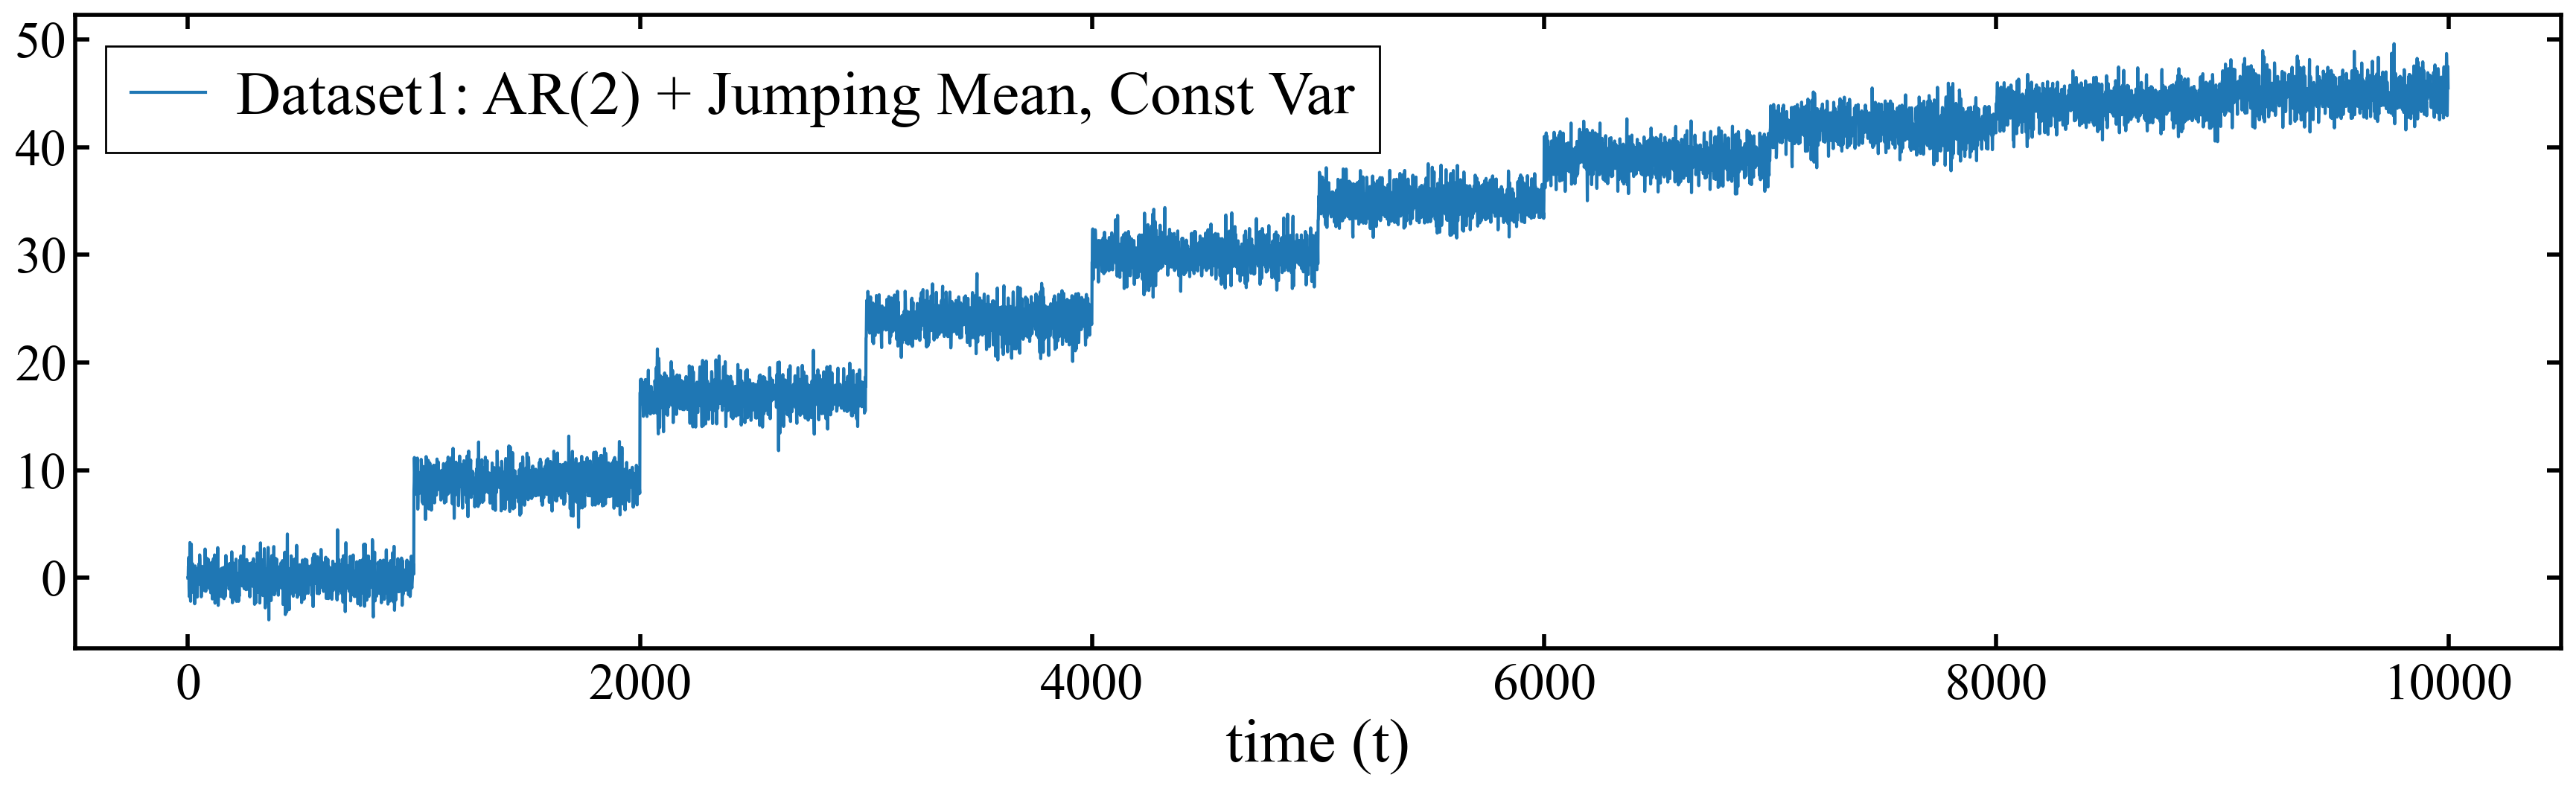

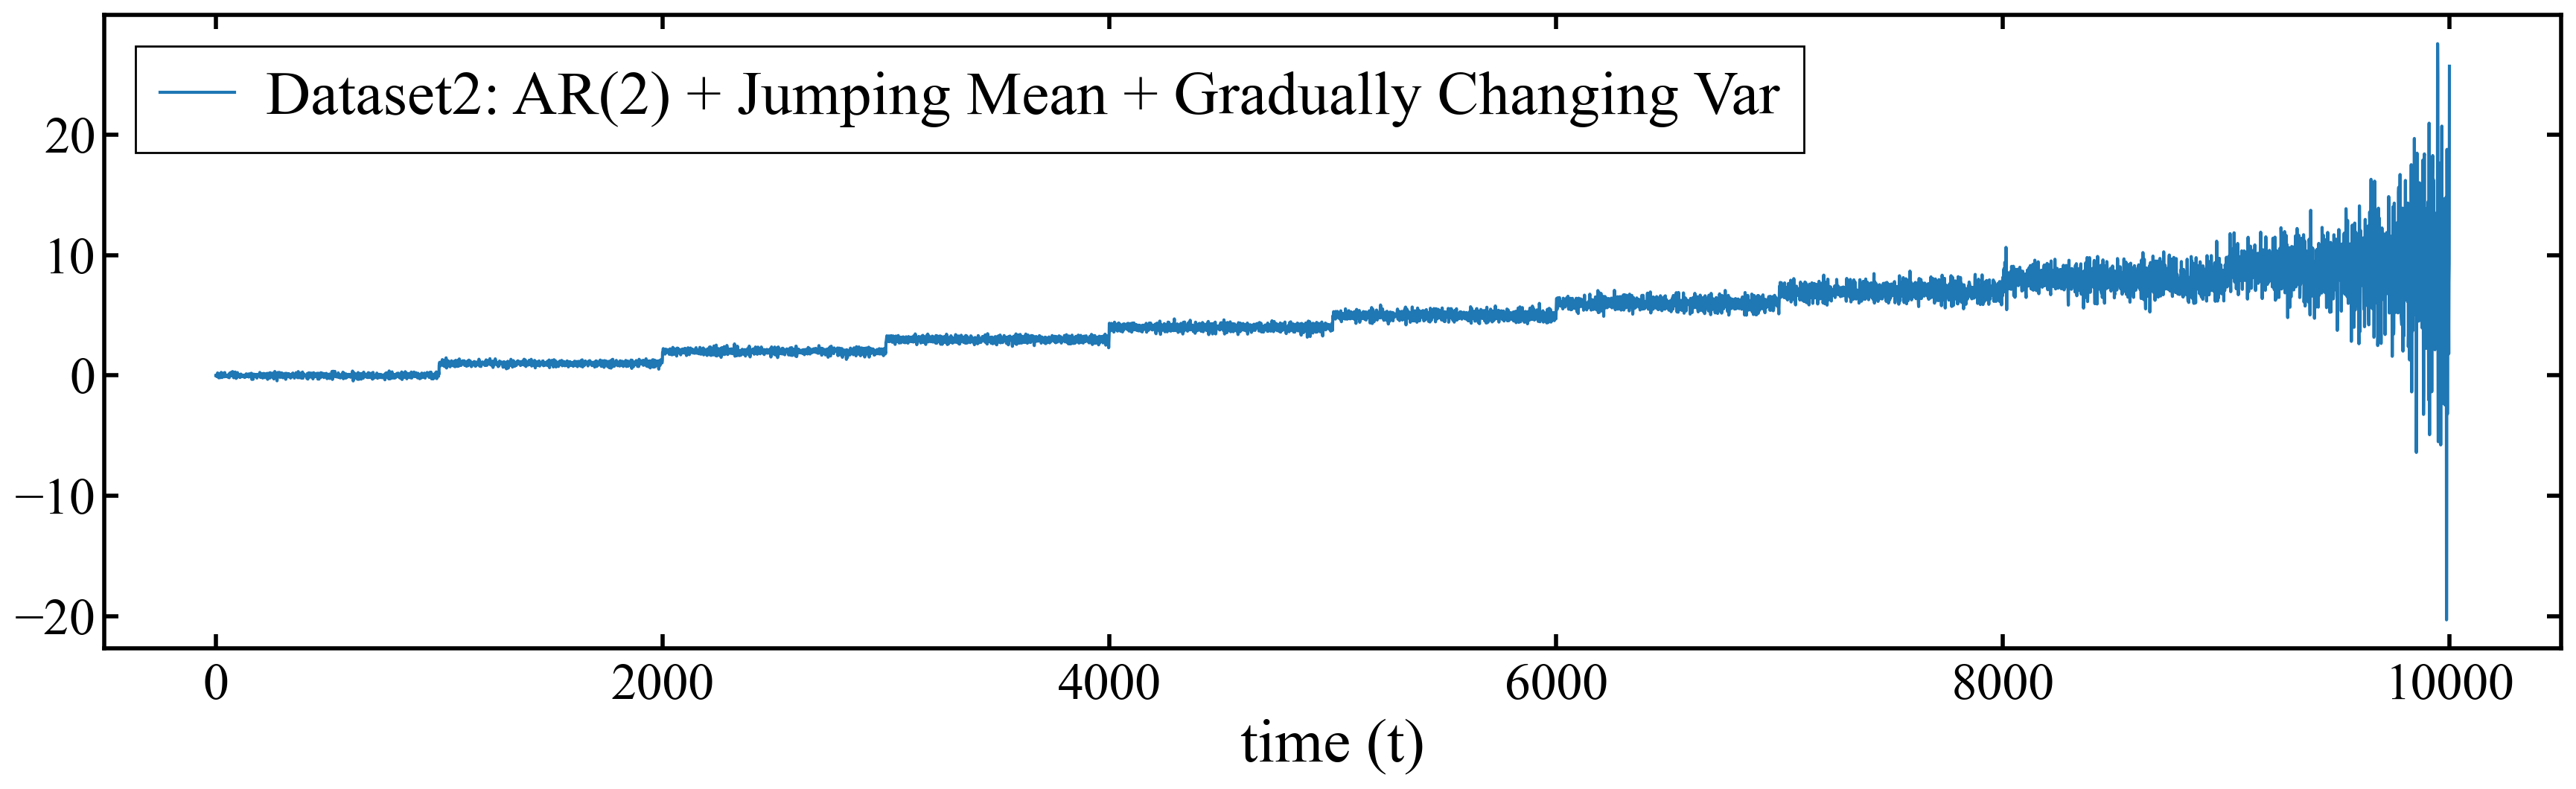

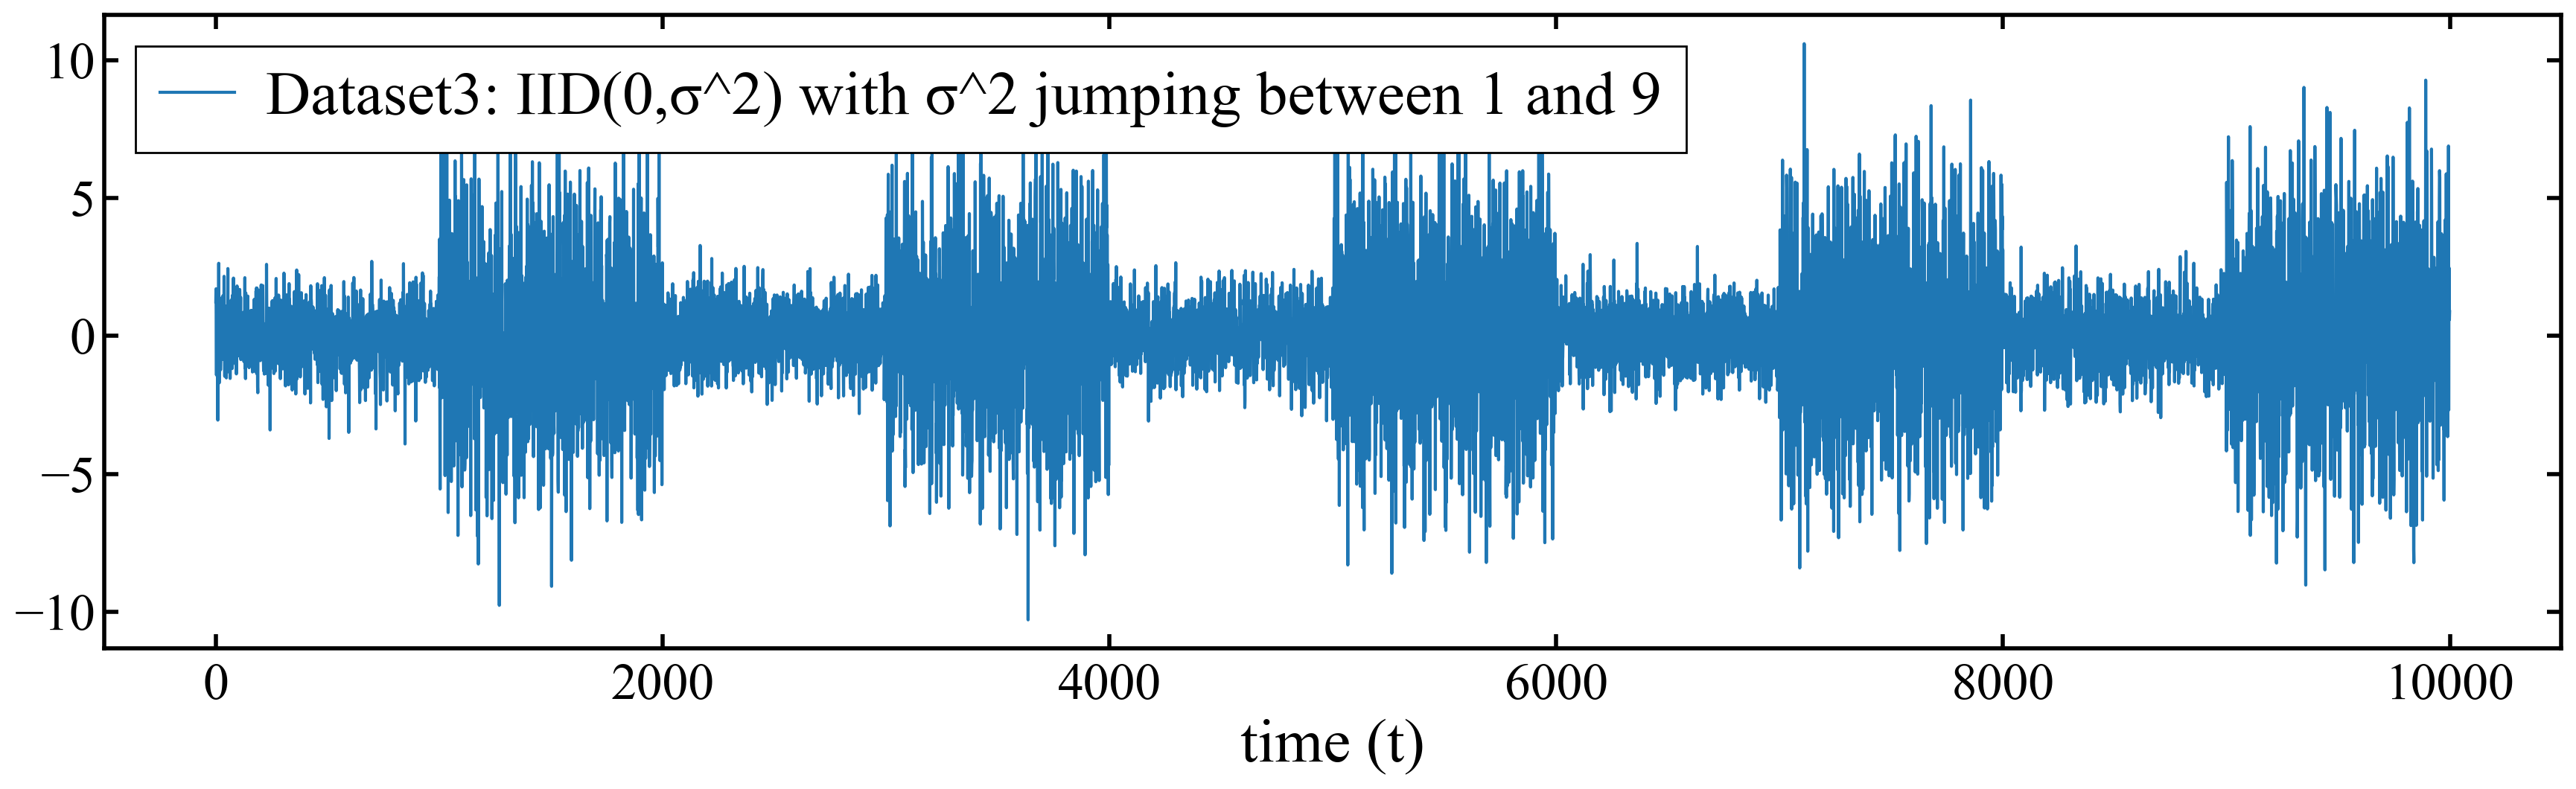

In [5]:
# ---
# ### 生成したデータをプロット
# ---

# データセット1のプロット
fig1, ax1 = plt.subplots(figsize=(18, 6), dpi=100)
default_ax(ax1)
ax1.plot(data1, label="Dataset1: AR(2) + Jumping Mean, Const Var")
# ax1.legend(loc="upper right")
ax1.set_xlabel("time (t)")
plt.legend()
plt.tight_layout()
plt.show()

# データセット2のプロット
fig2, ax2 = plt.subplots(figsize=(18, 6), dpi=100)
default_ax(ax2)
ax2.plot(data2, label="Dataset2: AR(2) + Jumping Mean + Gradually Changing Var")
# ax2.legend(loc="upper right")
ax2.set_xlabel("time (t)")
plt.legend()
plt.tight_layout()
plt.show()

# データセット3のプロット
fig3, ax3 = plt.subplots(figsize=(18, 6), dpi=100)
default_ax(ax3)
ax3.plot(data3, label="Dataset3: IID(0,σ^2) with σ^2 jumping between 1 and 9")
# ax3.legend(loc="upper right")
ax3.set_xlabel("time (t)")
plt.legend()
plt.tight_layout()
plt.show()

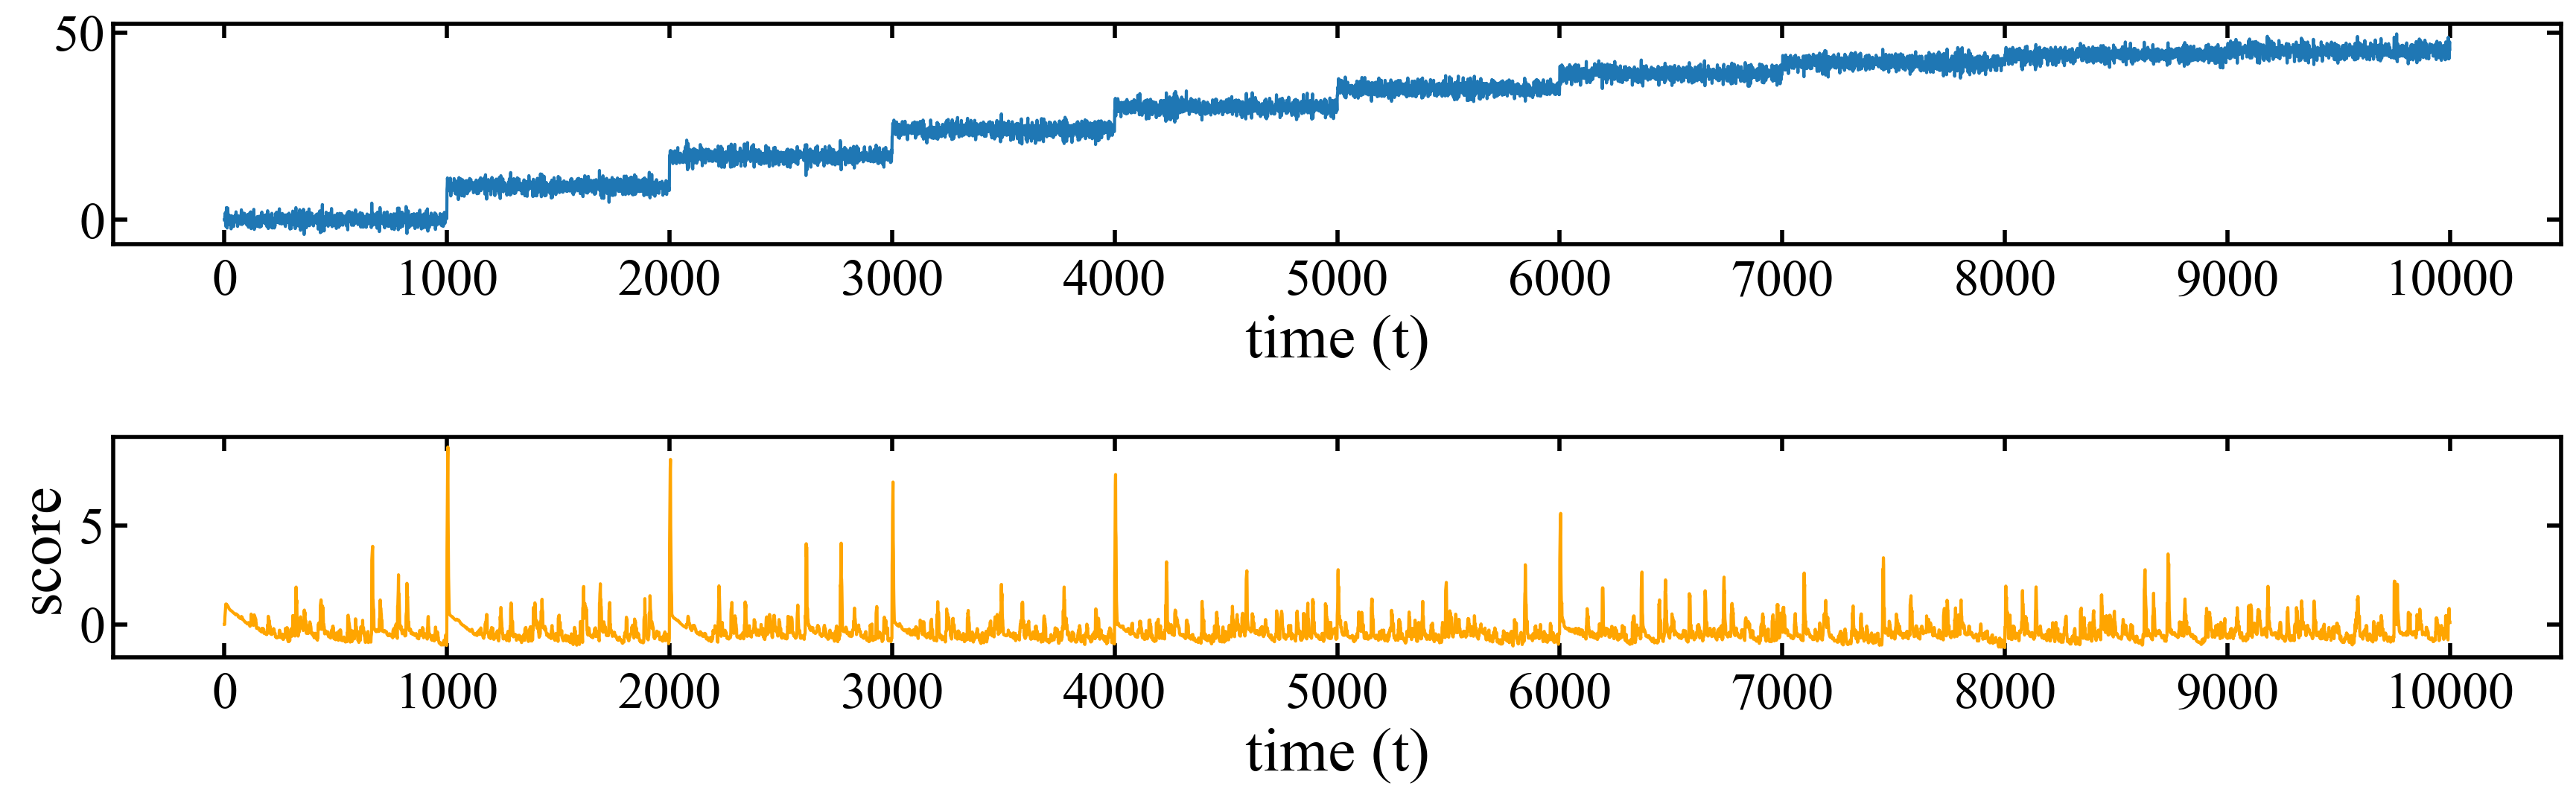

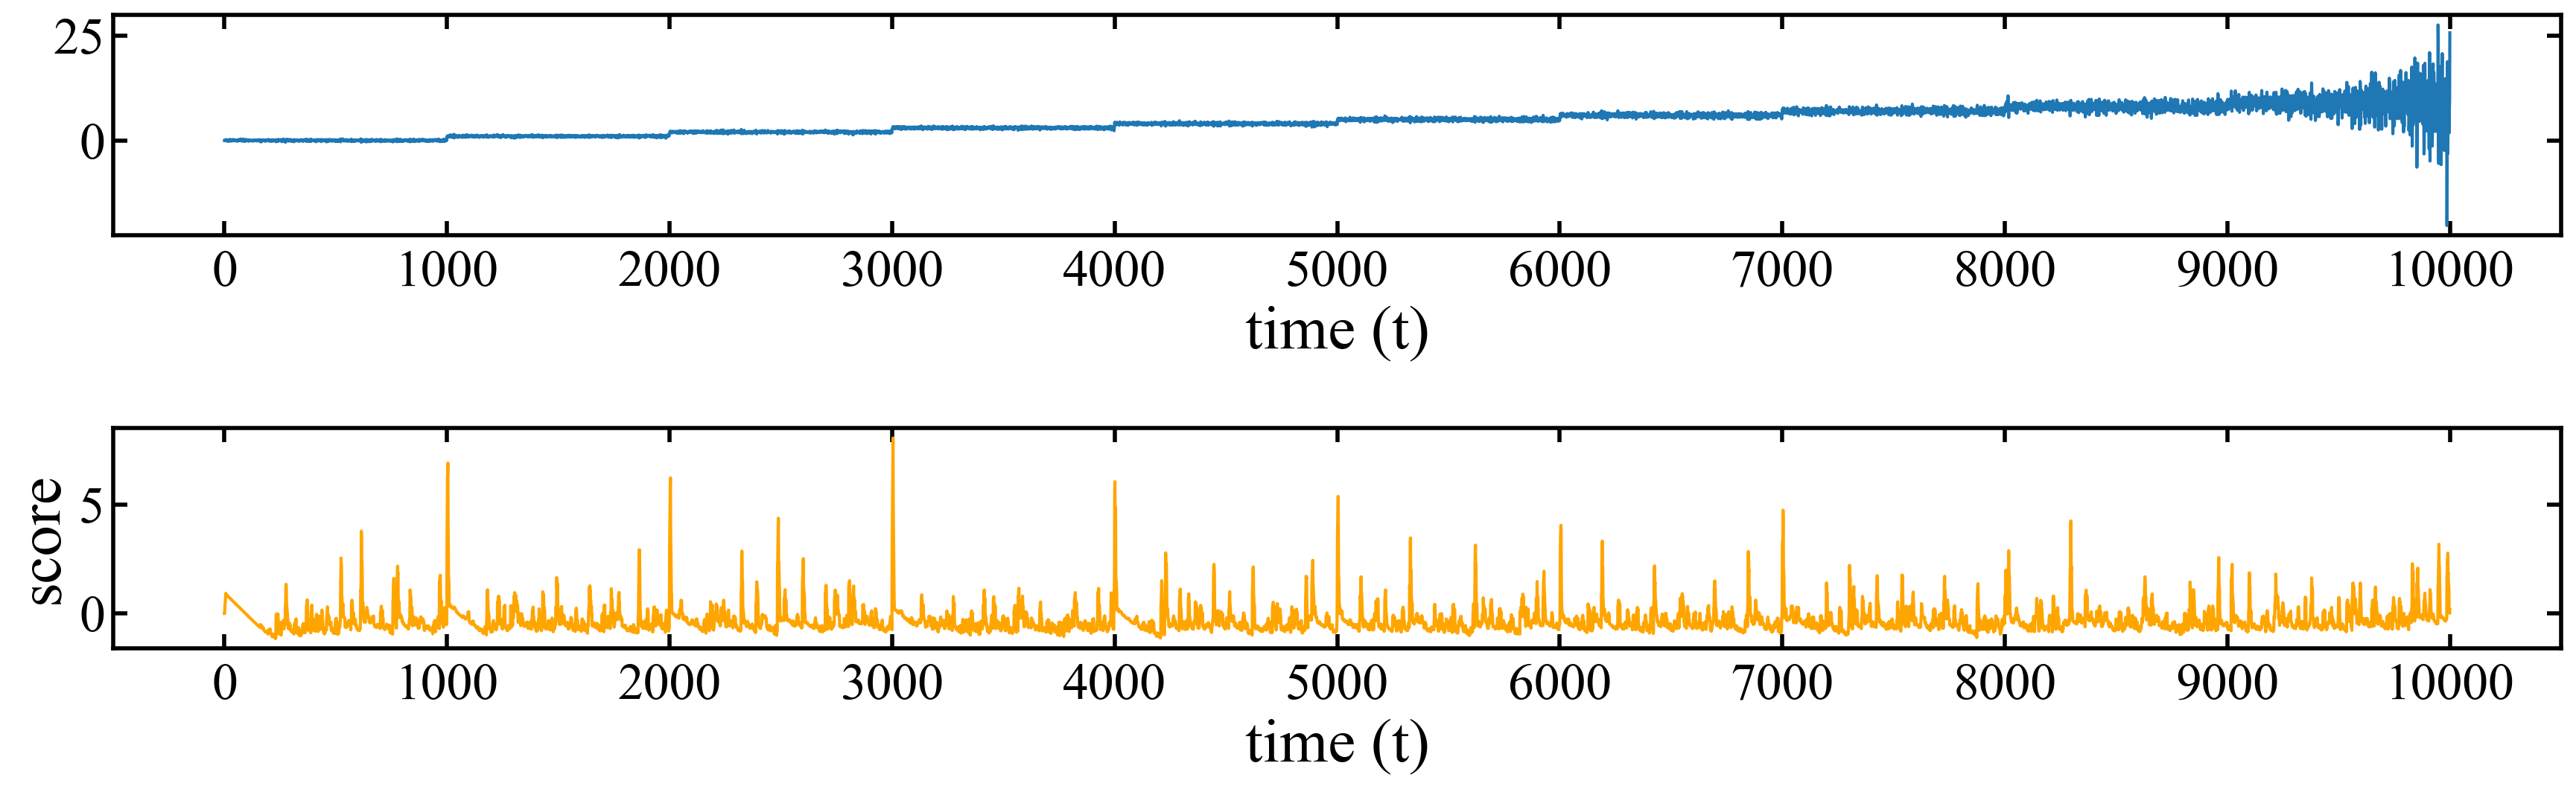

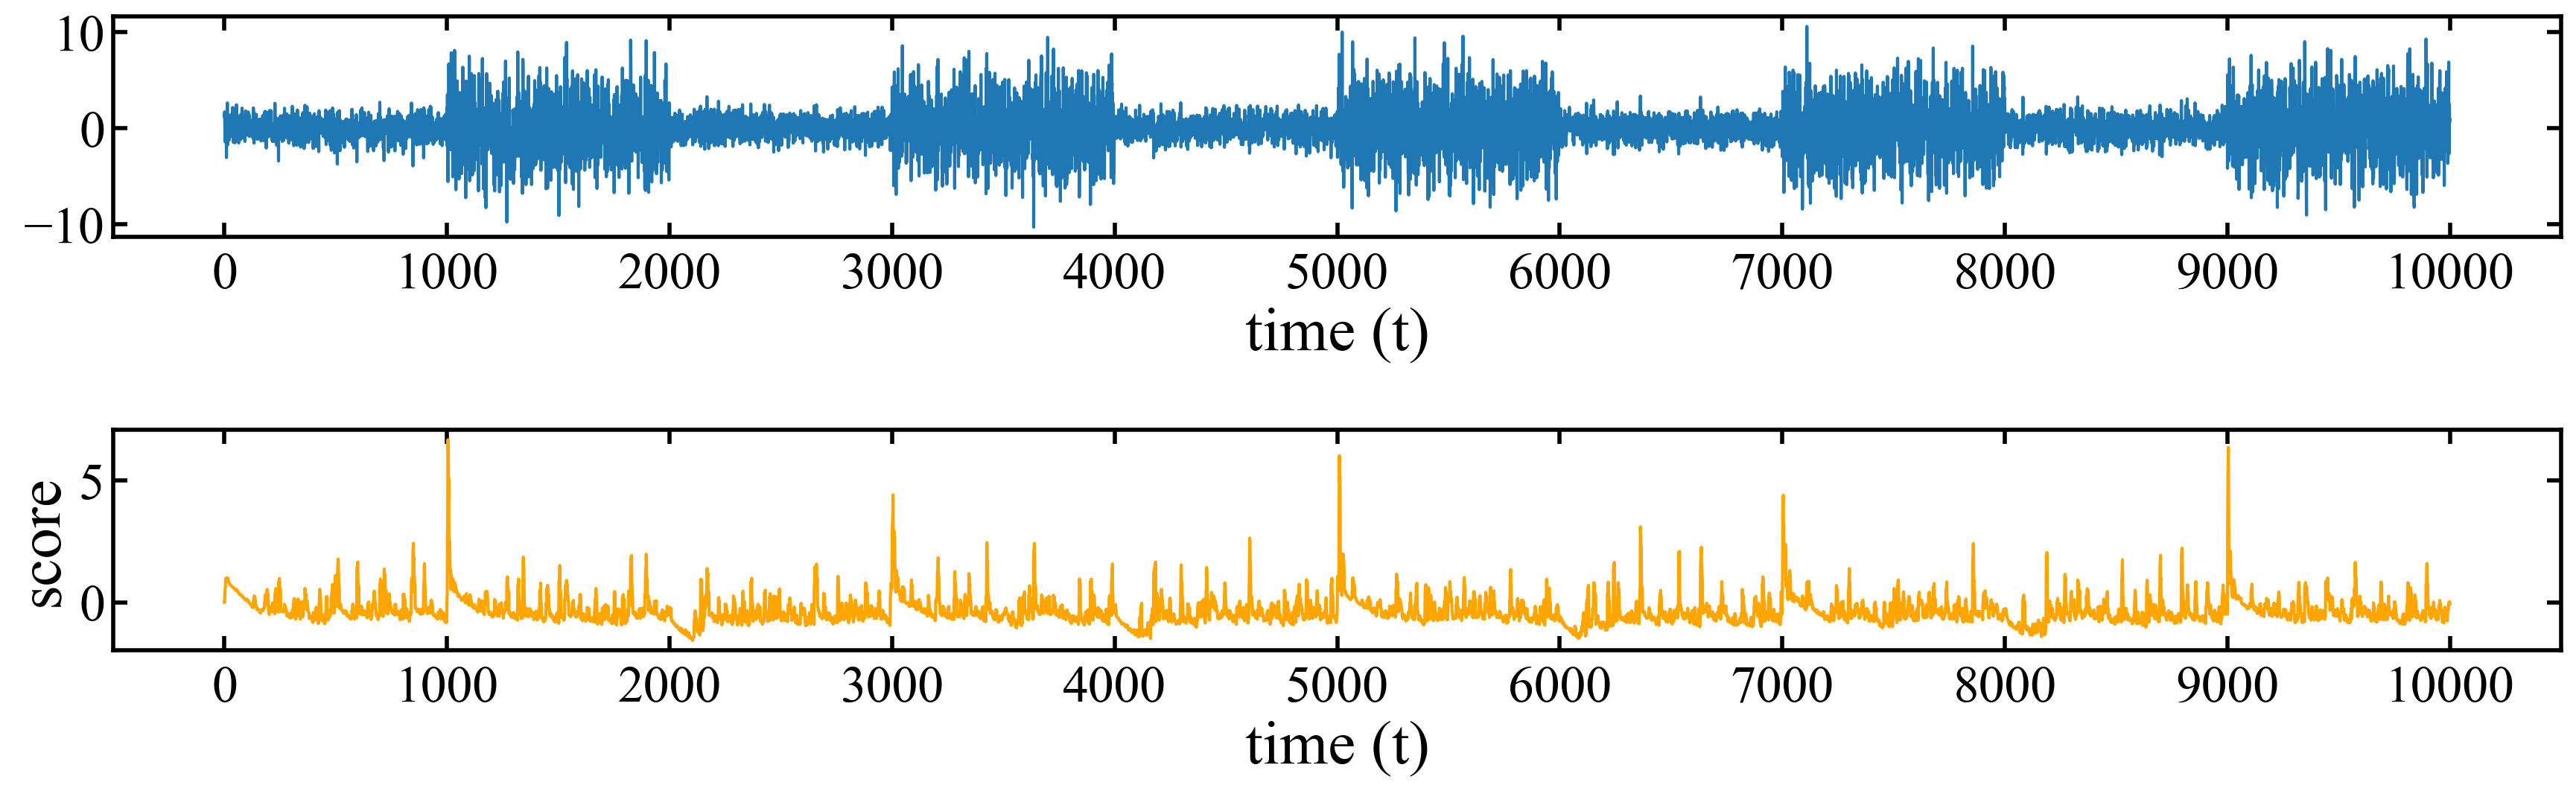

In [7]:
# ---
# ### ChangeFinder による変化点検知
# ---
from ChengeFinder import SDAR, ChangeFinder
# ChangeFinder のインスタンスを生成
cf1 = ChangeFinder(order1=1, order2=2, r=0.02, smooth_window1=5, smooth_window2=5)
cf2 = ChangeFinder(order1=1, order2=2, r=0.02, smooth_window1=5, smooth_window2=5)
cf3 = ChangeFinder(order1=1, order2=2, r=0.02, smooth_window1=5, smooth_window2=5)

# 各データセットに対して変化点スコアを計算
scores1 = cf1.process(data1)
scores2 = cf2.process(data2) 
scores3 = cf3.process(data3)

# データセット1の結果をプロット
fig1, (ax1a, ax1b) = plt.subplots(2, 1, figsize=(18, 6), dpi=100)
default_ax(ax1a)
default_ax(ax1b)
ax1a.plot(data1, label="Dataset1")
ax1a.set_xlabel("time (t)")
ax1a.set_xticks(range(0, 10001, 1000))
ax1b.plot(scores1, color='orange')
ax1b.set_xlabel("time (t)")
ax1b.set_ylabel("score")
ax1b.set_xticks(range(0, 10001, 1000))
plt.tight_layout()
plt.show()

# データセット2の結果をプロット
fig2, (ax2a, ax2b) = plt.subplots(2, 1, figsize=(18, 6), dpi=100)
default_ax(ax2a)
default_ax(ax2b)
ax2a.plot(data2, label="Dataset2")
ax2a.set_xlabel("time (t)")
ax2a.set_xticks(range(0, 10001, 1000))
ax2b.plot(scores2, color='orange')
ax2b.set_xlabel("time (t)")
ax2b.set_ylabel("score")
ax2b.set_xticks(range(0, 10001, 1000))
plt.tight_layout()
plt.show()

# データセット3の結果をプロット
fig3, (ax3a, ax3b) = plt.subplots(2, 1, figsize=(18, 6), dpi=100)
default_ax(ax3a)
default_ax(ax3b)
ax3a.plot(data3, label="Dataset3")
ax3a.set_xlabel("time (t)")
ax3a.set_xticks(range(0, 10001, 1000))
ax3b.plot(scores3, color='orange')
ax3b.set_xlabel("time (t)")
ax3b.set_ylabel("score")
ax3b.set_xticks(range(0, 10001, 1000))
plt.tight_layout()
plt.show()
